In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point

# Land use data

In [ ]:
# A data derived from VERISK landuse data
# Contains 6697 sample points, each with a landuse class

In [3]:
london_boundary = gpd.read_file("data/gis/london_boundary/london.shp")
# london_land_use = gpd.read_file("data/london_land_use_verisk_202209/london_land_use_verisk_202209.shp")

In [4]:
# Read the sampled points land use data
locs_landuse = gpd.read_file("data/landuse_classification/sampled_points_landuse.geojson")
locs_landuse

,landuse,landuse_id,loc_id,geometry
0,High density residential with retail and comme...,0,0,POINT (526097.941 191556.509)
1,High density residential with retail and comme...,0,1,POINT (509903.997 179914.470)
2,High density residential with retail and comme...,0,2,POINT (527851.149 172078.785)
3,High density residential with retail and comme...,0,3,POINT (538377.819 187462.431)
4,High density residential with retail and comme...,0,4,POINT (533271.207 197477.298)
...,...,...,...,...
6692,Recreational land,5,6692,POINT (514291.043 179185.329)
6693,Industrial areas,7,6693,POINT (548244.519 187401.078)
6694,Recreational land,5,6694,POINT (537744.752 162427.064)
6695,Industrial areas,7,6695,POINT (521173.875 182404.829)


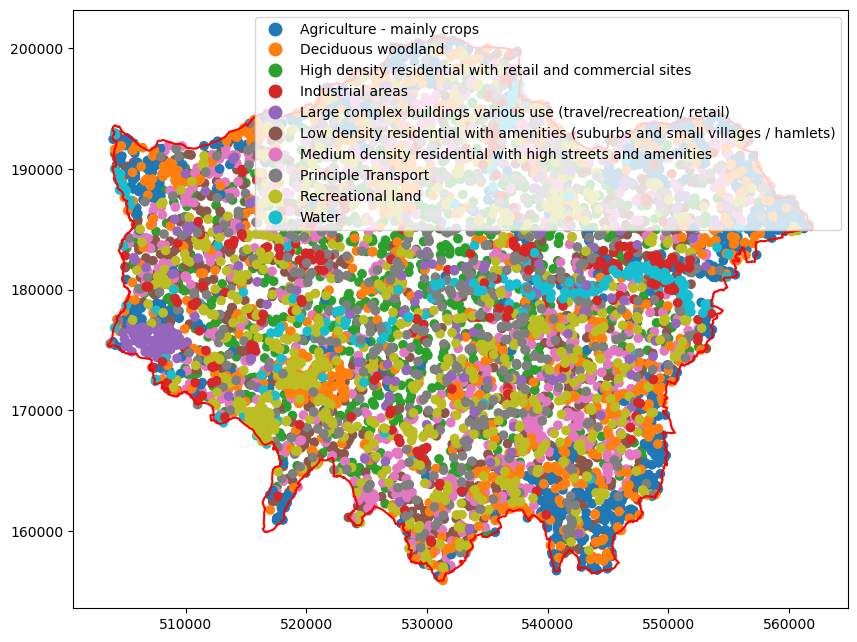

In [5]:
# Plot the downsampled points land use type distribution
fig, ax = plt.subplots(figsize=(10, 10))
london_boundary.boundary.plot(ax=ax, color="red")
locs_landuse.plot(ax=ax, column="landuse", legend=True, legend_kwds={"loc": "upper right"})
plt.show()

# Downstream supervised training

In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from model import LocCLIPLightning


In [8]:
# Helper function
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def load_model(ckpt_path, device, return_all=False):
    ckpt = torch.load(ckpt_path, map_location=device)
    lightning_model = LocCLIPLightning(**ckpt["hyper_parameters"]).to(device)
    lightning_model.load_state_dict(ckpt["state_dict"])
    lightning_model.eval()

    model = lightning_model.model

    if return_all:
        return model
    else:
        return model.loc_enc

In [ ]:
# Classifiers
class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)
    

# A non-linear classifier - a MLP with 1 hidden layer and ReLU activation
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# class RandomLocEncoder(nn.Module):
#     def __init__(self, num_sample, output_dim):
#         super(RandomLocEncoder, self).__init__()
#         self.embed = nn.Embedding(num_sample, output_dim)
#         # Freeze the embedding layer
#         self.embed.weight.requires_grad = False

#     def forward(self, x_idx):
#         return self.embed(x_idx)

In [10]:
# Dataset
# The LandUseDataset class: getitem returns a tuple of the id of land, coordinates of the land, and the land use type (id).
class LandUseDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        loc_inds = torch.tensor(row["loc_id"], dtype=torch.long)
        coords = torch.tensor([row["geometry"].x, row["geometry"].y])
        land_use_class = torch.tensor(row["landuse_id"], dtype=torch.long)
        return loc_inds, coords, land_use_class


In [11]:
# Read the sampled points land use data
locs_landuse = gpd.read_file("data/landuse_classification/sampled_points_landuse.geojson")
locs_landuse

,landuse,landuse_id,loc_id,geometry
0,High density residential with retail and comme...,0,0,POINT (526097.941 191556.509)
1,High density residential with retail and comme...,0,1,POINT (509903.997 179914.470)
2,High density residential with retail and comme...,0,2,POINT (527851.149 172078.785)
3,High density residential with retail and comme...,0,3,POINT (538377.819 187462.431)
4,High density residential with retail and comme...,0,4,POINT (533271.207 197477.298)
...,...,...,...,...
6692,Recreational land,5,6692,POINT (514291.043 179185.329)
6693,Industrial areas,7,6693,POINT (548244.519 187401.078)
6694,Recreational land,5,6694,POINT (537744.752 162427.064)
6695,Industrial areas,7,6695,POINT (521173.875 182404.829)


In [12]:
# Prepare the Dataset

# Train-val-test split
train_data, test_data = train_test_split(locs_landuse, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Dataset
train_dataset = LandUseDataset(train_data)
val_dataset = LandUseDataset(val_data)
test_dataset = LandUseDataset(test_data)

# DataLoader with batch size 128
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [13]:
# test the dataloader

for i, (inds, coords, land_use_class) in enumerate(val_loader):
    print(inds[:5], land_use_class[:5])
    

tensor([2761, 1479,  711,  103, 2113]) tensor([3, 1, 0, 0, 2])
tensor([1827, 1251, 1156, 3749,  910]) tensor([2, 1, 1, 4, 1])
tensor([5370,  484, 3037, 3042,  147]) tensor([8, 0, 3, 3, 0])
tensor([ 723, 1866, 6653, 3975, 6649]) tensor([0, 2, 8, 4, 9])
tensor([2214, 1916, 6065, 4347, 2123]) tensor([2, 2, 5, 4, 2])


In [ ]:
# Load the pretrained location encoder
device = "cuda:0"
ckpt_path = "checkpoints/epoch=63-val_loss=6.42.ckpt"
pretrianed_loc_encoder = load_model(ckpt_path, device=device)
for param in pretrianed_loc_encoder.parameters():
    param.requires_grad = False

In [20]:
# Training the downstream classifier
classifier_type = "linear"
# save_dir = "downstream_res/landuse/calliper_sphericalharmonics_fcnet/l40"
# save_dir = "downstream_res/landuse/calliper_spherec_fcnet/deg_min10_max360"
save_dir = "downstream_res/landuse/calliper_sentrans"

# create the save_dir if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for i, seed in enumerate([42, 24, 7, 0, 100]):
    set_seed(seed)
    print(f"============The {i+1}th run with seed {seed}===============")

    # Initialize the classifier
    if classifier_type == "linear":
        # Linear Probe
        clf = LinearProbe(128, 10).to(device)
    elif classifier_type == "nonlinear":
        # Non-linear Classifier
        clf = MLPClassifier(128, 64, 10).to(device)

    # Optimizer
    optimizer = optim.Adam(clf.parameters(), lr=0.001)

    # Loss
    criterion = nn.CrossEntropyLoss()

    # Training the downstream classifier

    num_epochs = 300
    train_losses = []
    val_losses = []
    if classifier_type == "linear":
        save_path = os.path.join(save_dir, f"linear_probe_best_{seed}.pth")
    elif classifier_type == "nonlinear":
        save_path = os.path.join(save_dir, f"nonlinear_clf_best_{seed}.pth")

    # Training the model, save the best model based on the validation loss, early stopping with patience of 10
    best_val_loss = float("inf")
    patience = 10
    counter = 0
    for epoch in range(num_epochs):
        clf.train()
        train_loss = 0
        for _, coords, land_use_class in train_loader:
            coords, land_use_class = coords.to(device), land_use_class.to(device)
            with torch.no_grad():
                loc_emb = pretrianed_loc_encoder(coords)
            optimizer.zero_grad()
            outputs = clf(loc_emb.float())
            loss = criterion(outputs, land_use_class)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        clf.eval()
        val_loss = 0
        with torch.no_grad():
            for _, coords, land_use_class in val_loader:
                coords, land_use_class = coords.to(device), land_use_class.to(device)
                loc_emb = pretrianed_loc_encoder(coords)
                outputs = clf(loc_emb.float())
                loss = criterion(outputs, land_use_class)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(clf.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1}")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                print("=====================================")
                break
print("Training finished!")

============The 1th run with seed 42===============
Epoch 1/300, Train Loss: 2.2128, Val Loss: 2.1127
Model saved at epoch 1
Epoch 2/300, Train Loss: 1.9447, Val Loss: 2.0282
Model saved at epoch 2
Epoch 3/300, Train Loss: 1.8706, Val Loss: 2.0041
Model saved at epoch 3
Epoch 4/300, Train Loss: 1.8261, Val Loss: 1.9841
Model saved at epoch 4
Epoch 5/300, Train Loss: 1.7966, Val Loss: 1.9764
Model saved at epoch 5
Epoch 6/300, Train Loss: 1.7720, Val Loss: 1.9649
Model saved at epoch 6
Epoch 7/300, Train Loss: 1.7540, Val Loss: 1.9628
Model saved at epoch 7
Epoch 8/300, Train Loss: 1.7430, Val Loss: 1.9668
Epoch 9/300, Train Loss: 1.7295, Val Loss: 1.9560
Model saved at epoch 9
Epoch 10/300, Train Loss: 1.7193, Val Loss: 1.9593
Epoch 11/300, Train Loss: 1.7086, Val Loss: 1.9636
Epoch 12/300, Train Loss: 1.7007, Val Loss: 1.9544
Model saved at epoch 12
Epoch 13/300, Train Loss: 1.6957, Val Loss: 1.9603
Epoch 14/300, Train Loss: 1.6878, Val Loss: 1.9640
Epoch 15/300, Train Loss: 1.6824, V

In [21]:
# Evaluate the model on the test set. Calculate the accuracy, precision, recall, and F1 score for each best model
# classifier_type = "nonlinear"
if classifier_type == "linear":
    model_paths = [os.path.join(save_dir, f"linear_probe_best_{seed}.pth") for seed in [42, 24, 7, 0, 100]]
elif classifier_type == "nonlinear":
    model_paths = [os.path.join(save_dir, f"nonlinear_clf_best_{seed}.pth") for seed in [42, 24, 7, 0, 100]]
metrics = []

for model_path in model_paths:
    # set_seed(i)
    if classifier_type == "linear":
        clf = LinearProbe(128, 10).to(device)
    elif classifier_type == "nonlinear":
        clf = MLPClassifier(128, 64, 10).to(device)
    
    clf.load_state_dict(torch.load(model_path))
    clf.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        for _, coords, land_use_class in test_loader:
            coords, land_use_class = coords.to(device), land_use_class.to(device)
            loc_emb = pretrianed_loc_encoder(coords)
            outputs = clf(loc_emb.float())
            _, predicted = torch.max(outputs, 1)
            y_true.extend(land_use_class.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    metrics.append({"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1})

metrics_df = pd.DataFrame(metrics)
metrics_df

,accuracy,precision,recall,f1
0,0.347015,0.363877,0.363335,0.353868
1,0.341791,0.379942,0.360091,0.356922
2,0.350746,0.364786,0.363085,0.352818
3,0.347015,0.377878,0.370499,0.361386
4,0.350000,0.375673,0.366796,0.358786


In [19]:
# Report the average accuracy, precision, recall, and F1 score
metrics_df.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.358060,0.380684,0.375194,0.362696
std,0.013069,0.018388,0.015208,0.016005
min,0.346269,0.363720,0.362219,0.346770
25%,0.347015,0.367695,0.362858,0.351256
50%,0.352985,0.371926,0.368475,0.355788
75%,0.370149,0.394121,0.386384,0.378228
max,0.373881,0.405957,0.396032,0.381435


In [22]:
metrics_df.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.347313,0.372431,0.364762,0.356756
std,0.003524,0.007553,0.003991,0.003516
min,0.341791,0.363877,0.360091,0.352818
25%,0.347015,0.364786,0.363085,0.353868
50%,0.347015,0.375673,0.363335,0.356922
75%,0.350000,0.377878,0.366796,0.358786
max,0.350746,0.379942,0.370499,0.361386
